# Deriving parameter estimation and uncertainties for laser plane measurement

## Preliminaries

In [8]:
from sympy import *
from sympy.interactive import printing
printing.init_printing(use_latex='mathjax')
import numpy as np
from sympy.matrices import *
from IPython.display import display

%matplotlib inline
from matplotlib import pyplot as plt

In [24]:
u, t, phi, phi_t, p, phi_p = symbols('u, t, \phi, \phi_t, p, \phi_p')
l_sym = symbols('l')

## Introduction and Model Equation and model Jacobian

We have multiple measurements $l_i$ at angular positions $\phi_i$. We want to determine parameters $p = [u, t, p, \phi_t, \phi_p]$, which minimizes deviations to the model $f$:

In [10]:
f = u + t*sin(phi+phi_t) + p *sin(2*(phi+phi_p))
f

p⋅sin(2⋅\phi + 2⋅\phiₚ) + t⋅sin(\phi + \phiₜ) + u

The non-linear and periodic nature of $\phi_t$ and $\phi_p$ make it difficult in the optimization steps. We replace the model by an equivalent one, using $sin$ and $cos$ to represent a sine function with phase shift.

In [29]:
t1, t2, p1, p2 = symbols('t_1, t_2, p_1, p_2')
f = u + t1 * sin(phi) + t2 * cos(phi) + p1 * sin(2*phi) + p2 * cos(2*phi)

f

p₁⋅sin(2⋅\phi) + p₂⋅cos(2⋅\phi) + t₁⋅sin(\phi) + t₂⋅cos(\phi) + u

with $t$ and $p$ to be reconstructed as follows:

In [30]:
t = sqrt(t1**2+t2**2)
t

   ___________
  ╱   2     2 
╲╱  t₁  + t₂  

and $p$ likewise.

We later will measure several points on the curve at positions $\phi_i$. We collect those observations within a vector $l=[l_1, l_2,...,l_k]$.
The above model equation $f$ depends on a set of parameters. We collect all parameters in a vector $p=[u, t_1, t_2, p_1, p_2]$.

Deviations between model and measurements can be written as $v_i = f(p, \phi_i) - l_i$. We can create a vector of deviations $v = [v_i]$.

Then the parameter fit needs to minimize $\Omega = v^T\,v$ by selecting an optimal set of parameters $p$.

We do this by iterative parameter improvements. We need to calculate the change of a deviation $v_i$ with respect to changes in a parameter $p_j$. Then we can do a non-linear least-squares minimization.

Formally we are looking for a Jacobian matrix like $J = [\frac{\partial v_i}{\partial p_j}]$, with the rows of $J$ corresponding to the different measurements, columns to different parameters.

The rows will differ only in $\phi$. We can describe the row derrivative vector $j_i(\phi_i) = \left[ \frac{\partial v_i}{\partial u} \frac{\partial v_i}{\partial t_1} \frac{\partial v_i}{\partial t_2} \frac{\partial v_i}{\partial p_1}  \frac{\partial v_i}{\partial p_2}\right]$ corresponding to the $i$-th measurement at angle $\phi_i$.

In [36]:
v_sym = f - l_sym

j_i = [diff(v_sym, u), diff(v_sym, t1), diff(v_sym, t2), diff(v_sym,p1), diff(v_sym, p2)]
j_i


[1, sin(\phi), cos(\phi), sin(2⋅\phi), cos(2⋅\phi)]

## Substitution for measurement setup

For the concrete measurement setup, we will have $k$ autocollimators measuring values. For convenience, we place them on equal angles around the module.
Knowing the position of the AC, we can now generate the matrix $J$ for this specific measurement setup (which will later on have an influence on the accuracy of the measurement setup).

In [143]:
# measurement setup angles phi_i
k = 8;
phis = np.linspace(0, 2*np.pi, k, endpoint=False)
# plug in phi_i values
j_row = Matrix(j_i).T
print(j_row)
J = Matrix([j_row.subs({phi:phi_i}) for phi_i in phis])
print("phi_i is: ", phi_i)
print("expression is: ",j_row.subs({phi:0.785398163397}))
phis = np.linspace(0, 2*np.pi, k, endpoint=False)
J


Matrix([[1, sin(\phi), cos(\phi), sin(2*\phi), cos(2*\phi)]])
phi_i is:  5.49778714378
expression is:  Matrix([[1, 0.707106781186230, 0.707106781186865, 1.00000000000000, 8.96677347027234e-13]])


⎡1           0                      1                      0                  
⎢                                                                             
⎢1   0.707106781186547      0.707106781186548             1.0           6.1232
⎢                                                                             
⎢1          1.0           6.12323399573677e-17   1.22464679914735e-16         
⎢                                                                             
⎢1   0.707106781186548     -0.707106781186547            -1.0           -1.836
⎢                                                                             
⎢1  1.22464679914735e-16          -1.0           -2.44929359829471e-16        
⎢                                                                             
⎢1   -0.707106781186547    -0.707106781186548             1.0           3.0616
⎢                                                                             
⎢1          -1.0          -1.83697019872103e-16  3.6

## Initial parameters

We need to choose initial values for our parameter vector. Not knowing anything about the module, we expect the errors to be small. So we choose $p_0 = [0, 0, 0, 0, 0]$.

To separate the parameter estimate $p_n$ from the potato chip amplitude $p$, we use pn as variable for the parameter estimate

In [44]:
# p0 - parameter vector p = [u, t1, t2, p1, p2]
pn = np.array((0,0,0,0,0))

## Create synthetic measurement data

Now we would be ready to make use of measurement data in form of a vector $l$.

Unfortunately, there's no real measurement data at hand. So we create synthetic data to have numbers to perform the calculation below.
Let's assume, we have a perfect module, slightly tilted ($p_{true}=[0, 10^{-4}, 0, 0, 0]$), and the autocollimators read values with measurement noise of $1$ arc second, then $\sigma_{AC} = 1/3600 * \frac{\pi}{180}$.

In [98]:
s_AC = np.deg2rad(1/3600)
s_AC

4.8481368111e-06

In [152]:
l = np.array([ 1e-4*np.sin(phi_i) + s_AC*np.random.randn() for phi_i in phis])
l

array([  4.77644622e-06,   7.32855469e-05,   9.14917057e-05,
         7.47618906e-05,   1.46645825e-05,  -6.89595486e-05,
        -9.13289208e-05,  -7.44017334e-05])

To illustrate, let's quickly draw the measurements

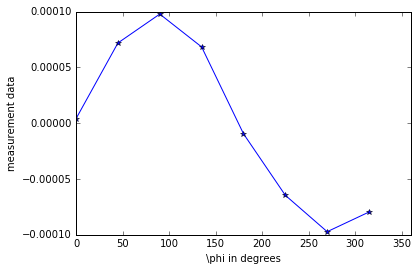

In [117]:
plt.plot(np.rad2deg(phis), l, '*-')
plt.xlim([0, 360])
plt.xlabel('\phi in degrees')
plt.ylabel('measurement data')

## Iteration procedure

We now iterate. To illustrate the process, we run the first iteration in detail and further iterations again below.

### Calculate difference between current model estimate and measurements

By fixing a parameter estimate $pn$, we settle on one shape that the laser plane should take in our measurements. This is a function $fn(\phi)$ and is given by the term below.

In [146]:
# store parameter substitutions, as they will be reused to calculate N below.
subsDict = {u:pn[0], t1:pn[1], t2:pn[2], p1:pn[3], p2:pn[4]}
print(subsDict)
fn = f.subs(subsDict)
fn


{u: 0, t_2: 0, p_2: 0, t_1: 0, p_1: 0}


0.0

To compare, how well our model fits, we evaluate the model at our measurement positions and consider the difference between model and measurements to obtain $v$.

In [129]:
l_est = [fn.subs({phi:phi_i}) for phi_i in phis]
print(fn.subs({phi:phi_i}))
l_est

0.0


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Let's check graphically, how our model fits to the measurements.

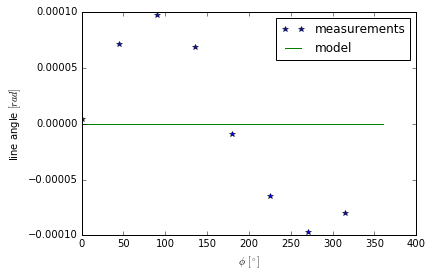

In [124]:
def plotModel(phis, fn, l):
    plt.plot(np.rad2deg(phis), l, '*')
    fn_modelFunc = np.vectorize(lambdify(phi, fn))
    xplot = np.linspace(0, 2*np.pi)
    plt.plot(np.rad2deg(xplot), fn_modelFunc(xplot))

    plt.legend(['measurements', 'model'])
    plt.xlabel(r'$\phi$ $[^\circ]$')
    plt.ylabel('line angle $[rad]$')
    
plotModel(phis, fn, l)

In [154]:
v = l_est - l
print(l)
print(v)

[  4.77644622e-06   7.32855469e-05   9.14917057e-05   7.47618906e-05
   1.46645825e-05  -6.89595486e-05  -9.13289208e-05  -7.44017334e-05]
[-4.77644622082425e-6 -7.32855468955243e-5 -9.14917056696936e-5
 -7.47618906217036e-5 -1.46645825046077e-5 6.89595485802005e-5
 9.13289208427197e-5 7.44017334302194e-5]


### Derive change to parameter estimate to improve fit

We use the Jacobian matrix determined above to obtain an adjustment to our parameter vector, which will reduce the residuals.

By playing around with the matrix equations, we can find an elegant way to obtain this estimate by looking at a so-called normal equation matrix $N = J^T\,J$ and a vector $n = J^T\,v$. This allows to solve the smaller system of equations $n = N \, dp$, solving for dp.

In [174]:
print(subsDict)
Jn = J.subs(subsDict)
Jn
N = Jn.T * Jn
n = Jn.T * v

{u: 0, t_2: 0, p_2: 0, t_1: 0, p_1: 0}


In [172]:
J

⎡1           0                      1                      0                  
⎢                                                                             
⎢1   0.707106781186547      0.707106781186548             1.0           6.1232
⎢                                                                             
⎢1          1.0           6.12323399573677e-17   1.22464679914735e-16         
⎢                                                                             
⎢1   0.707106781186548     -0.707106781186547            -1.0           -1.836
⎢                                                                             
⎢1  1.22464679914735e-16          -1.0           -2.44929359829471e-16        
⎢                                                                             
⎢1   -0.707106781186547    -0.707106781186548             1.0           3.0616
⎢                                                                             
⎢1          -1.0          -1.83697019872103e-16  3.6

In [173]:
Jn

⎡1           0                      1                      0                  
⎢                                                                             
⎢1   0.707106781186547      0.707106781186548             1.0           6.1232
⎢                                                                             
⎢1          1.0           6.12323399573677e-17   1.22464679914735e-16         
⎢                                                                             
⎢1   0.707106781186548     -0.707106781186547            -1.0           -1.836
⎢                                                                             
⎢1  1.22464679914735e-16          -1.0           -2.44929359829471e-16        
⎢                                                                             
⎢1   -0.707106781186547    -0.707106781186548             1.0           3.0616
⎢                                                                             
⎢1          -1.0          -1.83697019872103e-16  3.6

Then we can follow a standard Gauss-Newton (or Levenberg-Marquardt) method to calculate the improved parameters according to:

In [192]:
dp = N.solve(n)
dp
N.solve?

And obtain improved parameter estimations 

In [175]:
pn = pn - dp
pn

⎡3.03624613240174e-6 ⎤
⎢                    ⎥
⎢9.72194270468254e-5 ⎥
⎢                    ⎥
⎢-3.69506868896151e-6⎥
⎢                    ⎥
⎢9.91460280959885e-7 ⎥
⎢                    ⎥
⎣4.81956097461451e-6 ⎦

Repeat the process, until $|dp|$ is below a certain threshold.

In [190]:
sqrt(dp.dot(dp))


9.79166102643890e-21

needed 1 iterations.
popt:


⎡3.03624613240174e-6 ⎤
⎢                    ⎥
⎢9.72194270468254e-5 ⎥
⎢                    ⎥
⎢-3.69506868896151e-6⎥
⎢                    ⎥
⎢9.91460280959879e-7 ⎥
⎢                    ⎥
⎣ 4.8195609746145e-6 ⎦

residuals:


array([-6.15707802769515e-7, -3.12613248119637e-6, 3.94440653491908e-6,
       -1.35978051546588e-6, -3.11370670862994e-6, 6.85554699259583e-6,
       -7.67382104631854e-6, 5.08919502686532e-6], dtype=object)

target is:  9.79166102643890e-21
Couter is:  1


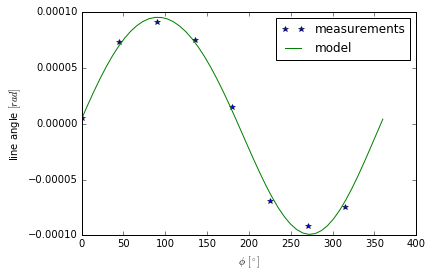

In [191]:
iterCount = 1 # set to 1, as first iteration is done above.
maxNumIter = 50
while sqrt(dp.dot(dp))>1e-18 and iterCount < maxNumIter:
    subsDict = {u:pn[0], t1:pn[1], t2:pn[2], p1:pn[3], p2:pn[4]}
    fn = f.subs(subsDict)
    l_est = [fn.subs({phi:phi_i}) for phi_i in phis]
    v = l_est - l
    Jn = J.subs(subsDict)
    N = Jn.T * Jn
    n = Jn.T * v
    dp = N.solve(n)
    print ('dp[{}]'.format(iterCount))
    display(dp)
    pn = pn - dp
    iterCount += 1

print ('needed {} iterations.'.format(iterCount))
popt = pn
print ('popt:')
display(popt)

print ('residuals:')
display(v)

plotModel(phis, fn, l)

print("target is: ",sqrt(dp.dot(dp)))
print("Couter is: ",iterCount)


## Reconstruct $t$ from $t_1, t_2$ and $p$

Using trigonometric identities, we can reconstruct $t$ and $p$ as:

In [207]:
u_v = pn[0]
t1_v = pn[1]
t2_v = pn[2]
p1_v = pn[3]
p2_v = pn[4]
t = sqrt(t1**2+t2**2)
p = sqrt(p1**2+p2**2)
print ('t:')
display(t)
print ('p:')
display(p)

paraValueSubs = {t1:t1_v, t2:t2_v, p1:p1_v, p2:p2_v}

print('umbrella: {:3.2f}mm@10m, tilt: {:3.2f}mm@10m, potato: {:3.2f}mm@10m'
            .format(u_v*1e4, t.subs(paraValueSubs)*1e4, p.subs(paraValueSubs)*1e4))

t:


   ___________
  ╱   2     2 
╲╱  t₁  + t₂  

p:


   ___________
  ╱   2     2 
╲╱  p₁  + p₂  

umbrella: 0.03mm@10m, tilt: 0.97mm@10m, potato: 0.05mm@10m


## Error/uncertanity model fit evaluation

After obtaining a fit, we could control the obtained solution to estimate the measurement uncertainty (if sufficient values are available) by looking at $\hat{s}_0^2 = v^Tv/(k-5)$. Unfortunately, as $k$ is only slightly larger than the number of parameters, this estimate is not reliable.

In [208]:
s0_est = sqrt(v.T.dot(v) / (k-5))
print ('estimated measurement uncertainty: {:3.1} mm@10m'.format(s0_est*1e4))

estimated measurement uncertainty: 0.08 mm@10m


In [209]:
Qxx = N.inv()
N

⎡          8            -2.22044604925031e-16  -5.55111512312578e-16  4.440892
⎢                                                                             
⎢-2.22044604925031e-16           4.0           3.33066907387547e-16   -1.11022
⎢                                                                             
⎢-5.55111512312578e-16  3.33066907387547e-16            4.0           1.110223
⎢                                                                             
⎢4.44089209850063e-16   -1.11022302462516e-16  1.11022302462516e-16           
⎢                                                                             
⎣-4.28626379701574e-16  8.10400147573914e-17   -3.35876613869193e-16  2.449293

09850063e-16   -4.28626379701574e-16⎤
                                    ⎥
302462516e-16  8.10400147573914e-17 ⎥
                                    ⎥
02462516e-16   -3.35876613869193e-16⎥
                                    ⎥
 4.0           2.44929359829471e-16 ⎥
                      

In [202]:
Qxx

⎡        0.125          6.93889390390723e-18   1.73472347597681e-17   -1.38777
⎢                                                                             
⎢6.93889390390723e-18           0.25           -2.08166817117217e-17  6.938893
⎢                                                                             
⎢1.73472347597681e-17   -2.08166817117217e-17          0.25           -6.93889
⎢                                                                             
⎢-1.38777878078145e-17  6.93889390390723e-18   -6.93889390390723e-18          
⎢                                                                             
⎣1.33945743656742e-17   -5.06500092233697e-18  2.09922883668246e-17   -1.53080

878078145e-17  1.33945743656742e-17 ⎤
                                    ⎥
90390723e-18   -5.06500092233697e-18⎥
                                    ⎥
390390723e-18  2.09922883668246e-17 ⎥
                                    ⎥
0.25           -1.53080849893419e-17⎥
                      

To make sense of $Q_{xx}$, we need to reconstruct u, t, and p from $pn$ and check for error propagation of the covariance from $Q_{xx}$ to the new covariance matrix.

In [211]:
dtdt1 = diff(t, t1).subs(paraValueSubs)
dtdt2 = diff(t, t2).subs(paraValueSubs)
dpdp1 = diff(p, p1).subs(paraValueSubs)
dpdp2 = diff(p, p2).subs(paraValueSubs)
print(paraValueSubs)

J_xk = np.array([[1, 0, 0, 0, 0], [0, dtdt1, dtdt2, 0, 0], [0, 0, 0, dpdp1, dpdp2]])
Q_xk = J_xk * Qxx * J_xk.T
Q_xk

{t_2: -3.69506868896151e-6, p_2: 4.81956097461450e-6, t_1: 9.72194270468254e-5, p_1: 9.91460280959879e-7}


⎡       0.125          6.27503791053967e-18   1.03235157085053e-17 ⎤
⎢                                                                  ⎥
⎢6.27503791053967e-18          0.25           -4.28821401301272e-18⎥
⎢                                                                  ⎥
⎣1.03235157085053e-17  -4.28821401301271e-18          0.25         ⎦

In [212]:
diff?

Note, that the covariance matrix is still mainly diagonal. So $u$, $t$ and $p$ remain mainly uncorrelated. As a consequence, we can ignore the off-diagonal elements and concentrate on the diagonal elements to provide an uncertainty for the parameters itself.

In [25]:
q_p = np.sqrt(np.array(np.diag(Q_xk), dtype=np.float))
q_p

array([ 0.35355339,  0.5       ,  0.5       ])

This means, that our setup roughly will reproduct the umbrella angle with 40% of the uncertainty of the autocollimator and the tilt and potato chip amplitude with 50-60%. The reason for this increase in certainty is due to the averaging.

We have only a few measurements $k$ more than the number of parameters ($5$). So, we cannot really trust $\hat{s}_0$. That is why we use the known measurement uncertainty $\sigma_{AC}$ and determine an estimate the uncertainty for the estimated parameters as obtained through error propagation.

In [26]:
s_p = s_AC * q_p
print ('uncertainty s_u: {:3.1}mm@10m, s_t: {:3.1}mm@10m, s_p: {:3.1}mm@10m'.format(s_p[0]*1e4, s_p[1]*1e4, s_p[2]*1e4))

uncertainty s_u: 0.02mm@10m, s_t: 0.02mm@10m, s_p: 0.02mm@10m
